In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange
    
from torchvision.ops import nms
from helper.drawer import *

# Prepare dataset and training
- Create random 5-image batch and pass it through model.
- We will evaluate loss via result image and intermediate output console

In [2]:
%matplotlib inline

from maintrainer.dataset import VOCYOLOAnnotator, VOCYolo

annotator = VOCYOLOAnnotator(
    annotation_root=r'C:\Dataset\VOCdevkit\VOC2008\Annotations',
    image_root=r'C:\Dataset\VOCdevkit\VOC2008\JPEGImages'
#     annotation_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/Annotations',
#     image_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

print(annotator.labels)

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: C:\Dataset\VOCdevkit\VOC2008\JPEGImages\2007_000027.jpg
Annotation[1]: [[14, 3, 3, 0.7664609053497946, 0.16400000000000015, 0.360082304526749, 0.5]]
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [3]:
import torchvision.transforms
from torchvision.transforms import *
import albumentations as A

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ]),
    augmentations=[
        A.PadIfNeeded(min_height=448, min_width=448),
        A.RandomCrop(width=448, height=448),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2)
    ]
)

inline_transform = transforms.Normalize(
    mean=[0.4547857, 0.4349471, 0.40525291],
    std=[0.12003352, 0.12323549, 0.1392444]
)

batch_size = 1
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=True)

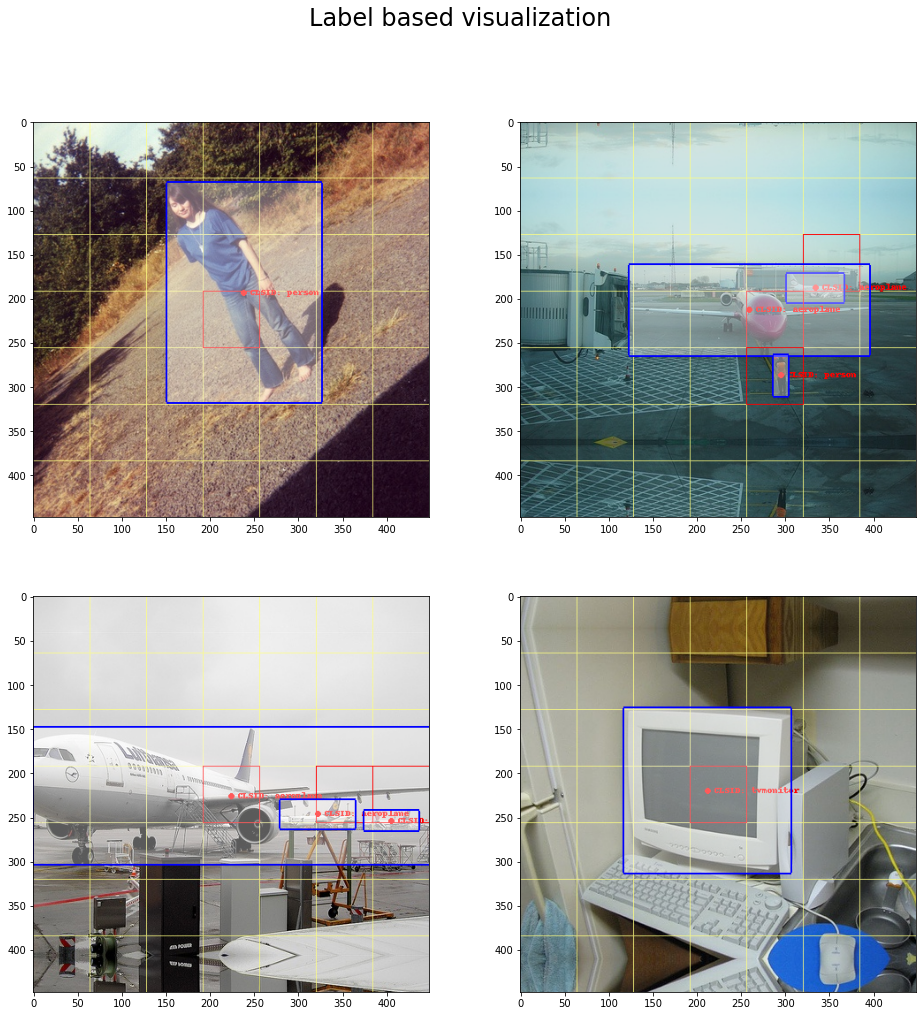

In [4]:
bunch_of_batch = []
for i, item in enumerate(train_dataloader):
    if i >= 4:
        break
    bunch_of_batch.append(item)

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Label based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image[:1, :, :, :])
    label = torch.squeeze(label[:1, :, :, :])
    
    image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object_label(image, annotator, label)
    ax.imshow(np.array(image))
    
plt.show()

In [5]:
def do_visualization(title = None, confidence_threshold = 0.8):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    with torch.no_grad():
        batched_image = torch.cat([image[:1, :, :, :] for image, label in bunch_of_batch], 0)
        batched_label = torch.cat([label[:1, :, :, :] for image, label in bunch_of_batch], 0)

        output = model(inline_transform(batched_image)).detach()
        
        output_images = []
        for i in range(output.shape[0]):
            output_images.append(output[i:i+1, :, :, :])

        for i, output in enumerate(output_images):
            ax = fig.add_subplot(2, 2, i + 1)

            image = torch.squeeze(batched_image[i])
            output = torch.squeeze(output)

            image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
            output = output.numpy()

            image = Image.fromarray(image)
            image = draw_cell_boundaries(image)
            image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=confidence_threshold)
            ax.imshow(np.array(image))
        plt.show()
    model.train()


In [6]:
from maintrainer.loss import YoloLoss
from model import YOLOv1, YOLOv1Pretrainer
import random
import os

PRETRAINED_WEIGHT = r'C:\Workspace\study-projects\yolov1-torch\prepare-torch\.pretrained\2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'
# PRETRAINED_WEIGHT = '.checkpoints/2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'

if not os.path.isfile(PRETRAINED_WEIGHT):
    print("Pretrained weight file %s not found!" % PRETRAINED_WEIGHT)
    exit(-1)

checkpoint = torch.load(PRETRAINED_WEIGHT)
# c_epoch = checkpoint['epoch'] + 1
c_model_state_dict = checkpoint['model_state_dict']
# c_optimizer_state_dict = checkpoint['optimizer_state_dict']
# c_loss = checkpoint['loss']

pretrainer = YOLOv1Pretrainer(classes=1000)
pretrainer.load_state_dict(c_model_state_dict)
model = YOLOv1(pretrainer).float()
# model.enable_features()
del pretrainer

YOLOv1: Loaded pretrained weights from Pretrainer
YOLOv1: Disabled pretrained parameter gradients


NewYoloLossV9 (CUDA not supported for now)
torch.Size([4, 3, 448, 448])
torch.Size([4, 25, 7, 7])


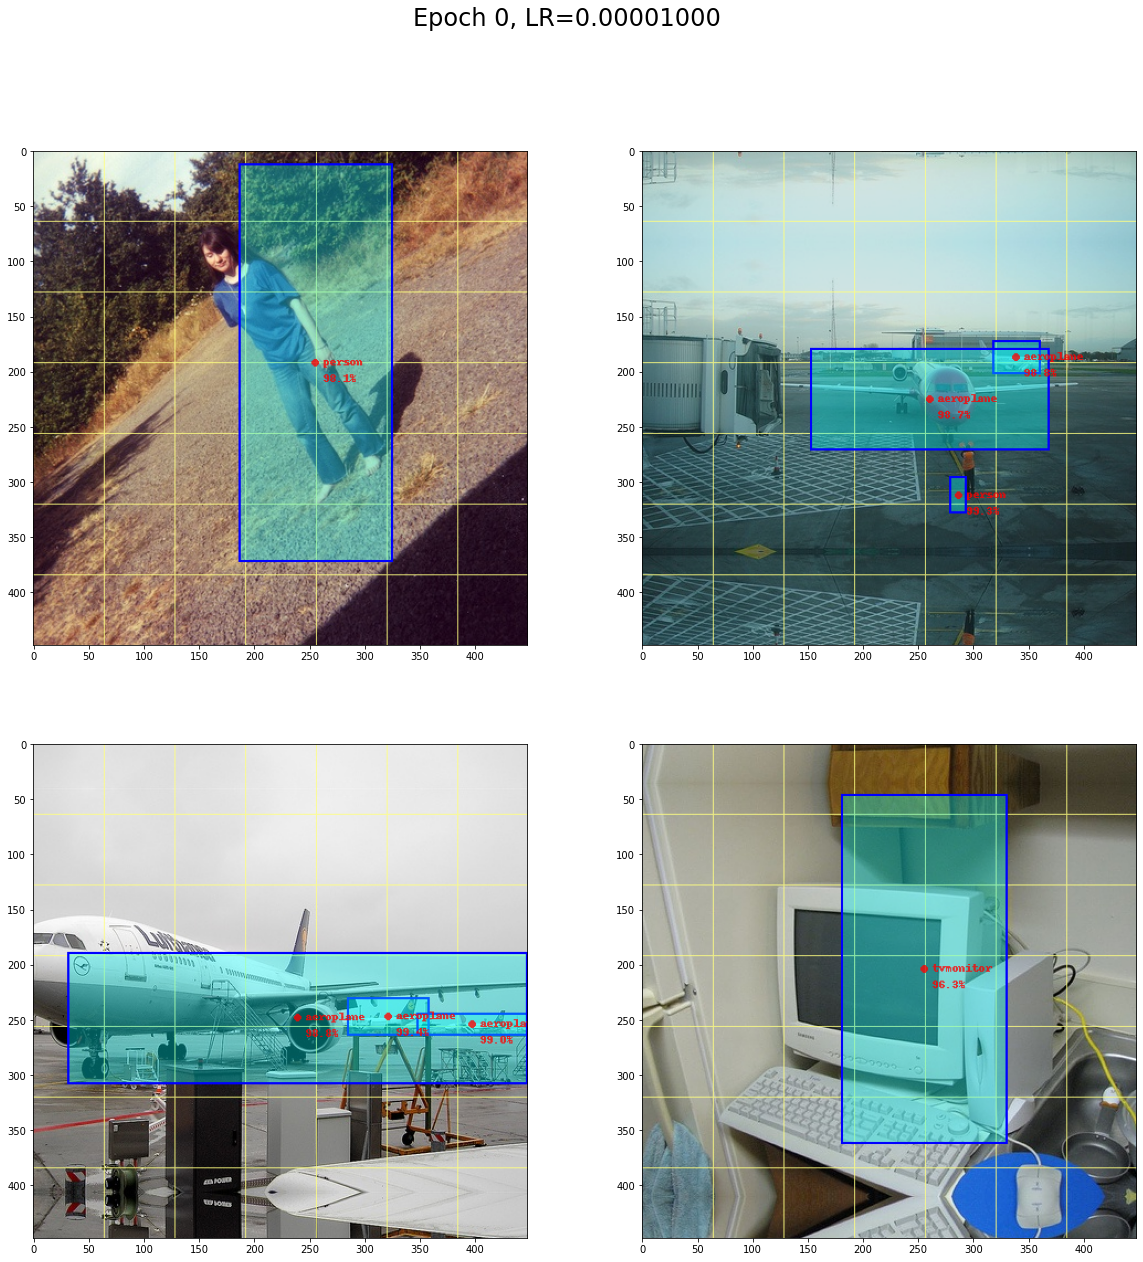

Epoch 0: Loss 0.018885 Acc 0.040816 AccT5 0.040816 xy_loss: 0.0154 wh_loss: 0.0008 conf_obj_loss: 0.0006 conf_noobj_loss: 0.0007 class_loss: 0.0015


KeyboardInterrupt: 

In [ ]:
from time import sleep

# Testing loss with given pseudo output!
visible_criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False, visible_output=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# batched_image = torch.cat([image for image, label in bunch_of_batch], 0)
# batched_label = torch.cat([label for image, label in bunch_of_batch], 0)

losses = []
xy_losses = []
wh_losses = []
conf_obj_losses = []
conf_noobj_losses = []
class_losses = []
class_accuracies = []
class_top_5_accuracies = []

batched_image = torch.cat([inline_transform(image) for (image, label) in bunch_of_batch], 0)
batched_label = torch.cat([label for (image, label) in bunch_of_batch], 0)

print(batched_image.shape)
print(batched_label.shape)

model = model
for epoch in range(1000):
#     random.shuffle(bunch_of_batch)
    # shuffle tensor
    _idxs = torch.randperm(batched_image.shape[0])
    batched_image = batched_image[_idxs].view(batched_image.size())
    batched_label = batched_label[_idxs].view(batched_label.size())
        
    output = model(batched_image)
#     loss = criterion(output, batched_label)
#     loss.backward()
    xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss = visible_criterion(output, batched_label)
#     print("\txy_loss: %.4f wh_loss: %.4f conf_obj_loss: %.4f conf_noobj_loss: %.4f class_loss: %.4f" % (
#             xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss))

    # ignore some of the losses
#         conf_noobj_loss = torch.Tensor([0])[0].cuda()
#         class_loss = torch.Tensor([0])[0].cuda()
    # End Ignore
    
    loss = torch.sum(torch.stack([xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss]))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    
    if epoch % 10 == 0:
        with torch.no_grad():
            if epoch % 100 == 0:
                do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']), confidence_threshold=0.4)
                
            output = output.cpu()

            xy_losses.append(xy_loss.item())
            wh_losses.append(wh_loss.item())
            conf_obj_losses.append(conf_obj_loss.item())
            conf_noobj_losses.append(conf_noobj_loss.item())
            class_losses.append(class_loss.item())
            
            model.eval()
#             class_accuracy = torch.sum(
#                 torch.eq(
#                     torch.argmax(torch.sigmoid(output[:, -20:, :, :]), dim=1),
#                     torch.argmax(batched_label, dim=1)
#                 ) * (batched_label[:, 4, :, :] == 1)
#             ) / torch.sum(batched_label[:, 4, :, :])
#             class_top_5_accuracy = torch.sum(
#                 torch.any(
#                     torch.eq(
#                         torch.argsort(torch.sigmoid(output[:, -20:, :, :]), dim=1)[:, -5:, :, :],
#                         torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
#                     ),
#                     dim=1
#                 ) * (batched_label[:, 4, :, :] == 1)
#             ) / torch.sum(batched_label[:, 4, :, :])
            class_accuracy = (
                torch.argmax(torch.sigmoid(output[:, -20:, :, :]), 1) == 
                torch.argmax(batched_label[:, -20:, :, :], 1)
            ) * batched_label[:, 4, :, :]
            class_accuracy = torch.mean(class_accuracy)
            class_top_5_accuracy = torch.any(
                torch.argsort(torch.sigmoid(output[:, -20:, :, :]), dim=1, descending=True)[:, :5, :, :] == 
                torch.argmax(batched_label[:, -20:, :, :], 1, keepdim=True).repeat(1, 5, 1, 1)
            ) * batched_label[:, 4, :, :]
            class_top_5_accuracy = torch.mean(class_top_5_accuracy)
            
            losses.append(loss.item())
            class_accuracies.append(class_accuracy.item())
            class_top_5_accuracies.append(class_top_5_accuracy.item())
            print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f xy_loss: %.4f wh_loss: %.4f conf_obj_loss: %.4f conf_noobj_loss: %.4f class_loss: %.4f" % (
                epoch, losses[-1], class_accuracies[-1], class_top_5_accuracies[-1], np.average(xy_losses),
                np.average(wh_losses), np.average(conf_obj_losses), np.average(conf_noobj_losses), np.average(class_losses))
             )
            model.train()
            
    losses = []
    xy_losses = []
    wh_losses = []
    conf_obj_losses = []
    conf_noobj_losses = []
    class_losses = []
    class_accuracies = []
    class_top_5_accuracies = []


#     output = model(batched_image)
#     loss = criterion(output, batched_label)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

#     with torch.no_grad():
#         losses.append(loss.item())

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle("Output based Custom visualization", fontsize=24)

model.eval()
with torch.no_grad():
    batched_image = torch.cat([image[:1, :, :, :] for image, label in bunch_of_batch], 0)
    batched_label = torch.cat([label[:1, :, :, :] for image, label in bunch_of_batch], 0)

    output = model(batched_image).detach()
    
    output_view_b1 = output[0, :, 3, 3]
    output_view_b1 = torch.cat([torch.sigmoid(output_view_b1[:10]), torch.log_softmax(output_view_b1[-20:], dim=0)])
    output_view_b2 = output[1, :, 3, 3]
    output_view_b2 = torch.cat([torch.sigmoid(output_view_b2[:10]), torch.log_softmax(output_view_b2[-20:], dim=0)])

    print(output_view_b1[:5].numpy(), output_view_b1[5:10].numpy())
    print(output_view_b1[-20:].numpy(), torch.argmax(output_view_b1[-20:], dim=0).numpy())
    print(output_view_b2[:5].numpy(), output_view_b2[5:10].numpy())
    print(output_view_b2[-20:].numpy(), torch.argmax(output_view_b2[-20:], dim=0).numpy())
    
    output_images = []
    for i in range(output.shape[0]):
        output_images.append(output[i:i+1, :, :, :])

    for i, output in enumerate(output_images):
        ax = fig.add_subplot(2, 2, i + 1)

        image = torch.squeeze(batched_image[i])
        output = torch.squeeze(output)
        
        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.8)
        ax.imshow(np.array(image))
    plt.show()
model.train()

for b in range(batched_label.shape[0]):
    bboxes = []
    for y in range(7):
        for x in range(7):
            current_batch_bbox = batched_label[b, :, y, x]
            if current_batch_bbox[4] == 0:
                continue
                
            cx, cy, w, h = current_batch_bbox[:4]
            cid = torch.argmax(current_batch_bbox[-20:])
            bboxes.append([x, y, cx, cy, w, h, cid])
            
    print("BBOX on batch %d:" % b, bboxes)

# Train with AMP!
- 날짜: 20210625
- 전전 셀에서 1e-5 LR을 이용하여 4장 이미지 (배치 셔플) 학습에 성공하였다!
- 이번에는 AMP에서도 가능할지 확인해본다.

In [ ]:
from time import sleep

# Testing loss with given pseudo output!
visible_criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False, visible_output=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# batched_image = torch.cat([image for image, label in bunch_of_batch], 0)
# batched_label = torch.cat([label for image, label in bunch_of_batch], 0)

losses = []
xy_losses = []
wh_losses = []
conf_obj_losses = []
conf_noobj_losses = []
class_losses = []
class_accuracies = []
class_top_5_accuracies = []

batched_image = torch.cat([inline_transform(image) for (image, label) in bunch_of_batch], 0)
batched_label = torch.cat([label for (image, label) in bunch_of_batch], 0)

scaler = torch.cuda.amp.GradScaler()

model = model.cuda()
for epoch in range(1000):
#     random.shuffle(bunch_of_batch)
    # shuffle tensor
    _idxs = torch.randperm(batched_image.shape[0])
    batched_image = batched_image[_idxs].view(batched_image.size())
    batched_label = batched_label[_idxs].view(batched_label.size())
        
    output = model(batched_image.cuda())
    with torch.cuda.amp.autocast(enabled=True):
        xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss = visible_criterion(output, batched_label.cuda())
        loss = torch.sum(torch.stack([xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss])).float()
        
    # loss.backward()
    scaler.scale(loss).backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    
    if epoch % 10 == 0:
        with torch.no_grad():
            if epoch % 100 == 0:
                do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']), confidence_threshold=0.4)
                
            output = output.cpu()

            xy_losses.append(xy_loss.item())
            wh_losses.append(wh_loss.item())
            conf_obj_losses.append(conf_obj_loss.item())
            conf_noobj_losses.append(conf_noobj_loss.item())
            class_losses.append(class_loss.item())
            
            model.eval()
            class_accuracy = torch.sum(
                torch.eq(
                    torch.argmax(torch.sigmoid(output[:, -20:, :, :]), dim=1),
                    torch.argmax(batched_label, dim=1)
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            class_top_5_accuracy = torch.sum(
                torch.any(
                    torch.eq(
                        torch.argsort(torch.sigmoid(output[:, -20:, :, :]), dim=1)[:, -5:, :, :],
                        torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
                    ),
                    dim=1
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            losses.append(loss.item())
            class_accuracies.append(class_accuracy.item())
            class_top_5_accuracies.append(class_top_5_accuracy.item())
            print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f xy_loss: %.4f wh_loss: %.4f conf_obj_loss: %.4f conf_noobj_loss: %.4f class_loss: %.4f" % (
                epoch, losses[-1], np.average(class_accuracies), np.average(class_top_5_accuracies), np.average(xy_losses),
                np.average(wh_losses), np.average(conf_obj_losses), np.average(conf_noobj_losses), np.average(class_losses))
             )
            model.train()
            
    losses = []
    xy_losses = []
    wh_losses = []
    conf_obj_losses = []
    conf_noobj_losses = []
    class_losses = []
    class_accuracies = []
    class_top_5_accuracies = []


#     output = model(batched_image)
#     loss = criterion(output, batched_label)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

#     with torch.no_grad():
#         losses.append(loss.item())